# Setup

## Jupyter Shell

In [1]:
shell = "ZMQInteractiveShell"
IN_JUPYTER = 'get_ipython' in globals() and \
            get_ipython().__class__.__name__ == shell

# Allow modules and files to be loaded with relative paths
from pkg_resources import resource_filename as fpath
import sys
sys.path.append(fpath(__name__, ""))

## Theme

In [2]:
if IN_JUPYTER:
    !jt -l
    # toggle toolbar ON and notebook name ON
    !jt -t grade3 -T -N

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


# Load Packages & Track Versions

In [3]:
# check the versions of key python librarise
# Python
import sys
import platform
print('python: %s' % platform.python_version())

python: 3.6.5


In [4]:
pkgs = [
    'numpy', 'matplotlib', 'pandas', 'statsmodels', 'sklearn', 'fbprophet',
    'numba'
]
for pkg in pkgs:
    try:
        globals()['est_module'] = __import__(pkg)
        print(pkg, ': %s' % est_module.__version__)
    except ModuleNotFoundError:
        print(pkg, 'Not Found')

numpy : 1.14.5
matplotlib : 2.2.2
pandas : 0.23.1
statsmodels : 0.9.0
sklearn : 0.19.1
fbprophet : 0.3
numba : 0.39.0


In [6]:
import os
if IN_JUPYTER:
    workspace_dir = os.path.realpath('..')
else:
    workspace_dir = os.getcwd()
print('Workspace Dir ->', workspace_dir )    

Workspace Dir -> /home/rajasoun/workspace/app-analytics


In [7]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import datetime
from numba import jit
import math

if IN_JUPYTER:
    import matplotlib.pyplot as plt
    %matplotlib inline

# Functions

In [8]:
def group_by_col(df, col):
    group = df.groupby(df[str(col)])
    group_by = pd.DataFrame(group.size().reset_index(name="Count"))
    return group_by

In [9]:
def delete_columns(df, cols):
    df = df.drop(list(cols), axis=1)
    return df

In [10]:
def print_cols_type(df):
    # Print Column Type
    for col in df:
        print(str(col), '->', type(df[col][1]))

In [11]:
def coerce_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [12]:
import dateutil
# Convert date from string to date times
def coerce_columns_to_date(df, col):
    df[str(col)] = df[str(col)].apply(dateutil.parser.parse, dayfirst=True)

In [13]:
#function to create a DataFrame in the format required by Prophet
def create_df_for_prophet(ts):
    ts.columns = ["ds", "y"]
    ts = ts.dropna()
    ts.reset_index(drop=True, inplace=True)
    return ts

In [14]:
from scipy import stats
import numpy as np
dir_name = workspace_dir + '/data/output/'


def remove_outliers_by_col(df, col):
    file = dir_name + 'outliers_' + str(col).lower() + '.csv'
    z = np.abs(stats.zscore(df[str(col)]))
    threshold = 3
    df[(z > 3)].to_csv(file, index=False)
    print('Removed Outliers Stores In ->', file)
    return df[(z < 3)]

In [15]:
def visualize_outliers_by_col(df, col):
    if IN_JUPYTER:
        import seaborn as sns
        sns.boxplot(x=df[str(col)])

In [16]:
#function to remove any negative forecasted values.
def remove_negtives(ts):
    ts['yhat'] = ts['yhat'].clip_lower(0)
    ts['yhat_lower'] = ts['yhat_lower'].clip_lower(0)
    ts['yhat_upper'] = ts['yhat_upper'].clip_lower(0)
    return ts

In [17]:
import math

def mse(y_actual, y_pred):
    # compute the mean square error
    mse = ((y_actual - y_pred)**2).mean()
    return mse

In [18]:
# Symmetric Mean Absolute Percent Error (SMAPE)
#function to calculate in sample SMAPE scores
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        if (y_true[i] != None and np.isnan(y_true[i]) == False):
            a = y_true[i]
            b = y_pred[i]
            c = a + b
            if c == 0:
                continue
            out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [19]:
def visualize_user_access(df):
    if IN_JUPYTER:
        df.set_index('ds').plot(style=['+'])
        plt.xlabel('Date')
        plt.ylabel('Users')
        plt.title('User Access By Date')
        plt.show()

In [20]:
def visualize_forecast(df):
    if IN_JUPYTER:
        mdl.plot(df)
        plt.show()

In [21]:
def visualize_forecast_details(df):
    if IN_JUPYTER:
        # plot time series components
        mdl.plot_components(df)
        plt.show()

In [64]:
def convert_notebook_to_python():
    !jupyter nbconvert --to=python notebook demand_forecast_by_ga.ipynb
    !ls

# Sanity Check - Input Data

In [22]:
#import required data
from subprocess import check_output
input_dir = workspace_dir + "/data/input/"
print(check_output(["ls", input_dir ]).decode("utf8"))

est_daily_access.csv
us_holidays.csv



# Predict - From Google Analytics Data

## Load & Clean Up Data

In [23]:
max_date_past_data = '2018-10-23' #str(clean_ga_data.ds.max().date())
data_file = workspace_dir + "/data/input/est_daily_access.csv"

ga_data = pd.read_csv(data_file)
m = ga_data.shape[0]
n = ga_data.shape[1]

print('        Data Set Details')
print('+++++++++++++++++++++++++++++++')
print('# Of Observations', str(m))
print('# Of Features', str(n))

        Data Set Details
+++++++++++++++++++++++++++++++
# Of Observations 2197
# Of Features 2


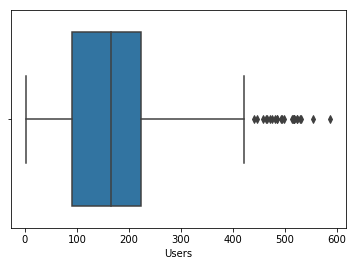

In [24]:
visualize_outliers_by_col(ga_data, 'Users')

In [25]:
ga_data = remove_outliers_by_col(ga_data, 'Users')
m = ga_data.shape[0]
print(' Data Set without Outliers')
print('+++++++++++++++++++++++++++++++')
print('# Of Observations', str(m))
ga_data.tail()

Removed Outliers Stores In -> /home/rajasoun/workspace/app-analytics/data/output/outliers_users.csv
 Data Set without Outliers
+++++++++++++++++++++++++++++++
# Of Observations 2173


,Date,Users
2192,8/29/18,174
2193,8/30/18,156
2194,8/31/18,159
2195,09/01/18,60
2196,09/02/18,9


In [26]:
clean_ga_data = create_df_for_prophet(ga_data)
coerce_columns_to_numeric(clean_ga_data, ['y'])
coerce_columns_to_date(clean_ga_data,'ds')
print_cols_type(clean_ga_data)
clean_ga_data.tail()

ds -> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
y -> <class 'numpy.int64'>


,ds,y
2168,2018-08-29,174
2169,2018-08-30,156
2170,2018-08-31,159
2171,2018-01-09,60
2172,2018-02-09,9


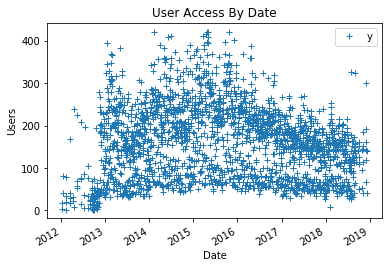

In [27]:
visualize_user_access(clean_ga_data)

In [28]:
# log transform data
ga_data['y'] = np.log(ga_data['y'])
ga_data.tail()

,ds,y
2192,8/29/18,5.159055
2193,8/30/18,5.049856
2194,8/31/18,5.068904
2195,09/01/18,4.094345
2196,09/02/18,2.197225


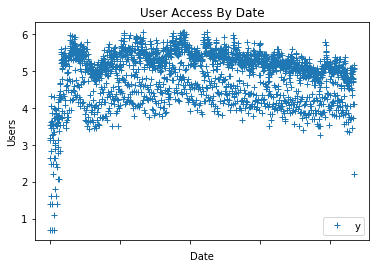

In [29]:
visualize_user_access(ga_data)

## Prediction

In [30]:
holidays_csv = workspace_dir + "/data/input/us_holidays.csv"
us_public_holidays = pd.read_csv(holidays_csv)
mdl = Prophet(
    interval_width=0.95,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=us_public_holidays)
mdl.fit(ga_data)

ga_future = mdl.make_future_dataframe(
    periods=31 + 28, freq='D', include_history=True)
ga_forecast = mdl.predict(ga_future)

In [31]:
ga_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2227,2018-10-27,3.976248,3.477569,4.469213
2228,2018-10-28,3.566237,3.131152,4.020612
2229,2018-10-29,4.737975,4.247097,5.174665
2230,2018-10-30,4.911723,4.446590,5.411254
2231,2018-10-31,4.936604,4.444485,5.419583


In [32]:
np.exp(ga_forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
2227,53.316639,32.380898,87.287967
2228,35.383211,22.900348,55.735221
2229,114.202699,69.902167,176.737466
2230,135.873339,85.335424,223.912111
2231,139.296461,85.156020,225.784869


In [33]:
ga_forecast = remove_negtives(ga_forecast)

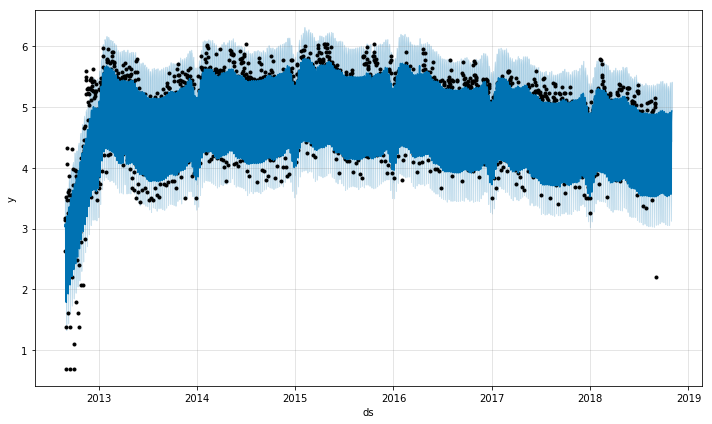

In [34]:
visualize_forecast(ga_forecast)

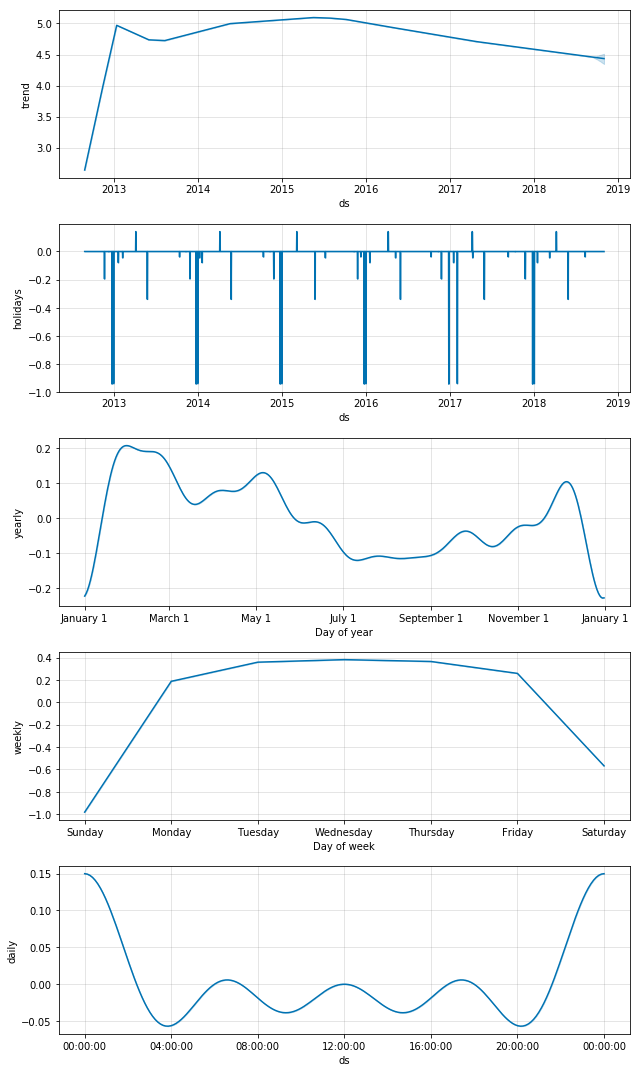

In [35]:
visualize_forecast_details(ga_forecast)

In [ ]:
ga_forecast['yhat'] = np.exp(ga_forecast[['yhat']])
ga_forecast['yhat_lower'] = np.exp(ga_forecast[['yhat_lower']])
ga_forecast['yhat_upper'] = np.exp(ga_forecast[['yhat_upper']])

ga_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
modelling_csv = workspace_dir + "/data/output/prediction_based_ga_modelling.csv"
ga_forecast.to_csv(modelling_csv)

In [ ]:
# retransform using e
y_hat = ga_forecast['yhat'][:]
y_true = clean_ga_data['y']
mse = mse(y_hat, y_true)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

In [ ]:
y_prediction = ga_forecast['yhat'][:]
y_actual = clean_ga_data['y']
smape = smape_fast(y_actual.values, y_prediction.values)
print('Prediction quality: SMAPE :  {:.2f}  '.format(smape))

In [ ]:
prediction = ga_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
column_headers = [
    'Date', 'PredictedUser', 'Lower(PredictedUser)', 'Upper(PredictedUser)'
]
prediction.columns = column_headers
forecast_csv = workspace_dir + '/data/output/forecast_for_future.csv'
prediction_future = prediction[prediction.Date > max_date_past_data]
prediction_future.to_csv(forecast_csv, index=False)
prediction_future.tail()

In [ ]:
ds = ga_forecast[['ds']]
actual = clean_ga_data['y']
forecast = ga_forecast[['yhat', 'yhat_lower', 'yhat_upper']]
frames = [ds, actual, forecast]
column_headers = [
    'Date', 'ActualUser', 'PredictedUser', 'Lower(PredictedUser)',
    'Upper(PredictedUser)'
]
result = pd.concat(frames, axis=1, join='inner')
result.columns = column_headers
forecast_csv = workspace_dir + '/data/output/forecast_for_past.csv'
result.to_csv(forecast_csv, index=False)
result.tail()

# Convert Jupyter Notebook to Python

In [66]:
if IN_JUPYTER:
    convert_notebook_to_python()

[NbConvertApp] WARNING | pattern 'notebook' matched no files
[NbConvertApp] Converting notebook demand_forecast_by_ga.ipynb to python
[NbConvertApp] Writing 8237 bytes to demand_forecast_by_ga.py
demand_forecast_by_ga.ipynb  demand_forecast_by_ga.py  setup.ipynb
